In [57]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# 比較する音源ファイルのリスト
files = ['separated/htdemucs/metal/drums.mp3', 'separated/htdemucs/blues/drums.mp3', 'separated/htdemucs/rock/drums.mp3','separated/htdemucs/pop/drums.mp3']
labels=['metal','blues','rock','pop']

/var/folders/2t/9z6r93h91nx56fpp3_wvn0zr0000gn/T/ipykernel_40977/3682825772.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


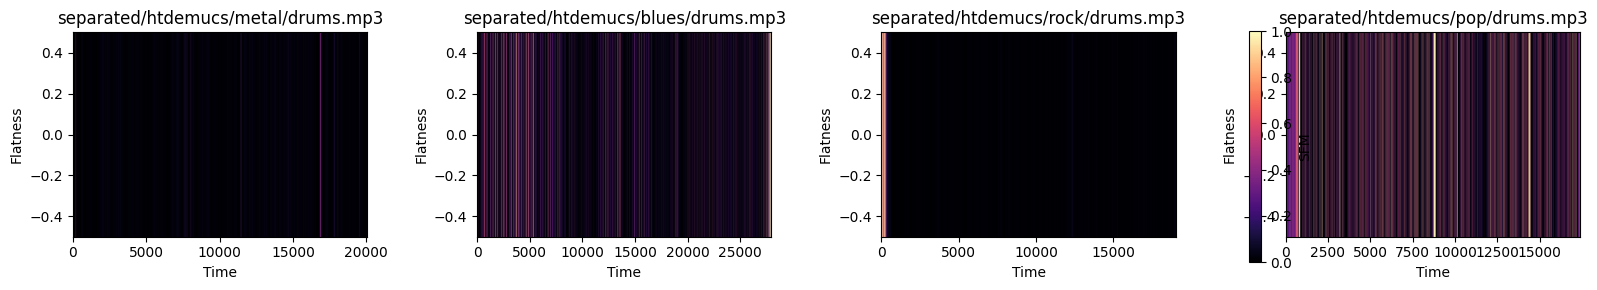

In [39]:
# SFMリストを格納
sfm_list = []
titles = []

# 計算＆保存
for filename in files:
    y, sr = librosa.load(filename, sr=None)
    sfm = librosa.feature.spectral_flatness(y=y)
    
    # 前処理：前後の異常値カット（オプション）
    threshold = np.percentile(sfm, 95)
    valid = np.where(sfm[0] < threshold)[0]
    start, end = valid[0], valid[-1]
    sfm_trimmed = sfm[:, start:end]

    sfm_list.append(sfm_trimmed)
    titles.append(filename)

# カラースケールの最大値を合わせる（99%パーセンタイル）
vmax_all = np.percentile(np.hstack(sfm_list), 99)

# 描画
n = len(sfm_list)
fig, axes = plt.subplots(1, n, figsize=(4*n, 3))

for i, sfm in enumerate(sfm_list):
    ax = axes[i] if n > 1 else axes
    ax.imshow(sfm, aspect='auto', origin='lower', cmap='magma', vmin=0, vmax=vmax_all)
    ax.set_title(titles[i])
    ax.set_xlabel('Time')
    ax.set_ylabel('Flatness')

fig.colorbar(plt.cm.ScalarMappable(cmap='magma'), ax=axes.ravel().tolist(), label='SFM')
plt.tight_layout()
plt.show()


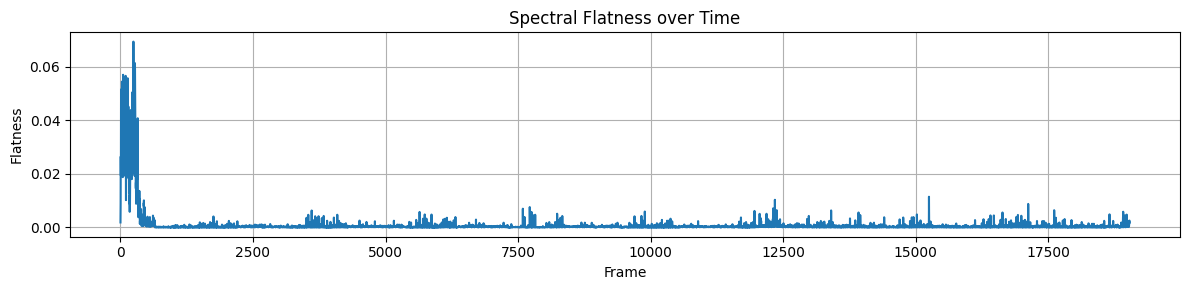

In [37]:
plt.figure(figsize=(12, 3))
plt.plot(sfm_trimmed[0])
plt.title("Spectral Flatness over Time")
plt.xlabel("Frame")
plt.ylabel("Flatness")
plt.grid(True)
plt.tight_layout()
plt.show()


In [43]:
import pandas as pd

features = []

for filename in files:
    y, sr = librosa.load(filename, sr=None)
    sfm = librosa.feature.spectral_flatness(y=y)[0]

    # 前処理：異常に高い部分のカット（オプション）
    threshold = np.percentile(sfm, 99)
    valid = np.where(sfm < threshold)[0]
    sfm = sfm[valid]

    # 特徴量の計算
    feature = {
        'filename': filename,
        'sfm_mean': np.mean(sfm),
        'sfm_var': np.var(sfm),
        'sfm_median': np.median(sfm),
        'sfm_min': np.min(sfm),
        'sfm_max': np.max(sfm),
        # 'sfm_p90': np.percentile(sfm, 90),
        # 'sfm_p95': np.percentile(sfm, 95),
        # 'sfm_p99': np.percentile(sfm, 99),
        # 'sfm_peak1': np.sort(sfm)[-1],      # 最大ピーク
        # 'sfm_peak2': np.sort(sfm)[-2],      # 2番目
        # 'sfm_peak3': np.sort(sfm)[-3],      # 3番目
    }

    features.append(feature)

# DataFrameで表形式に
df = pd.DataFrame(features)
print(df)


                             filename  sfm_mean   sfm_var  sfm_median  \
0  separated/htdemucs/metal/drums.mp3  0.000772  0.000007    0.000216   
1  separated/htdemucs/blues/drums.mp3  0.003693  0.000046    0.000410   
2   separated/htdemucs/rock/drums.mp3  0.000602  0.000006    0.000158   
3    separated/htdemucs/pop/drums.mp3  0.007428  0.000123    0.001428   

        sfm_min   sfm_max  
0  2.258984e-07  0.047338  
1  1.048056e-07  0.052510  
2  1.884020e-06  0.027255  
3  6.939329e-08  0.055241  


In [44]:
# パラメータ
n_bands = 24  # サブバンド数（24バンドで分割）

# 結果を保存
sfm_band_features = []

for filename in files:
    # 音声読み込み
    y, sr = librosa.load(filename, sr=None)

    # メルスペクトログラム計算
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_bands, fmax=sr//2)

    # 各バンドごとのSFMを計算（平均）
    geo_mean = np.exp(np.mean(np.log(np.maximum(S, 1e-10)), axis=1))  # ジオ平均
    arith_mean = np.mean(S, axis=1)  # 算術平均
    sfm_bands = geo_mean / arith_mean  # 各バンドのSFM

    # 特徴ベクトルを保存
    feature = {'filename': filename}
    for i in range(n_bands):
        feature[f'sfm_band_{i+1}'] = sfm_bands[i]
    sfm_band_features.append(feature)

# DataFrameにまとめる
df_sfm = pd.DataFrame(sfm_band_features)

# 表示
print(df_sfm)


                             filename  sfm_band_1  sfm_band_2  sfm_band_3  \
0  separated/htdemucs/metal/drums.mp3    0.088180    0.020703    0.046386   
1  separated/htdemucs/blues/drums.mp3    0.003766    0.002054    0.001502   
2   separated/htdemucs/rock/drums.mp3    0.078555    0.063153    0.059270   
3    separated/htdemucs/pop/drums.mp3    0.000860    0.000667    0.001882   

   sfm_band_4  sfm_band_5  sfm_band_6  sfm_band_7  sfm_band_8  sfm_band_9  \
0    0.049755    0.062280    0.062022    0.069909    0.081073    0.089965   
1    0.002830    0.002205    0.001812    0.002026    0.002251    0.002154   
2    0.073657    0.074134    0.058847    0.056702    0.074976    0.081828   
3    0.002040    0.002237    0.003615    0.003544    0.003703    0.004108   

   ...  sfm_band_15  sfm_band_16  sfm_band_17  sfm_band_18  sfm_band_19  \
0  ...     0.114541     0.123166     0.137845     0.148712     0.144478   
1  ...     0.006802     0.007748     0.008913     0.009686     0.012346   
2  

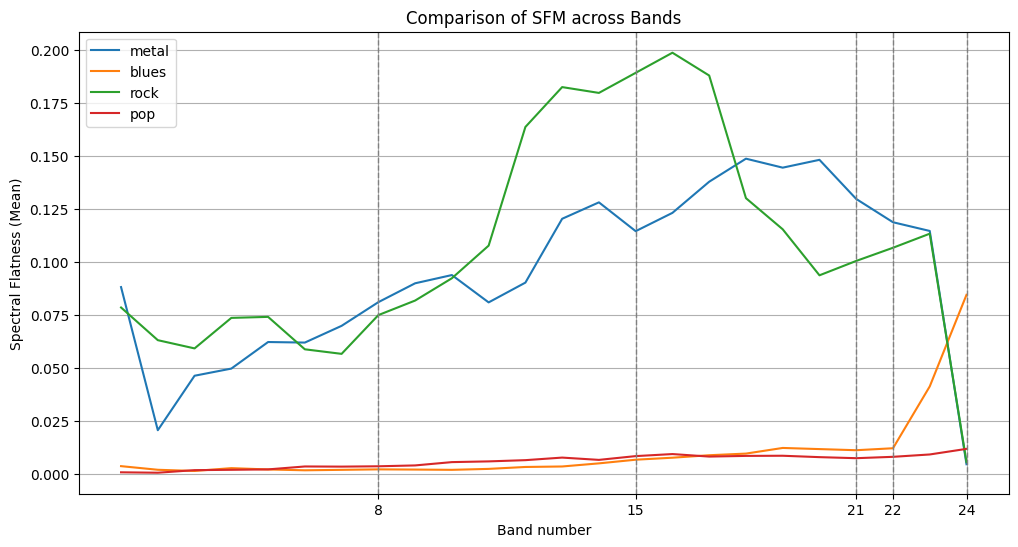

In [53]:
# グラフで比較
plt.figure(figsize=(12, 6))

for idx, row in df_sfm.iterrows():
    sfm_values = row.values[1:]  # filenameを除く
    plt.plot(range(1, n_bands + 1), sfm_values, label=row['filename'])

important_bands = [8, 15, 21, 22, 24]

for band in important_bands:
    plt.axvline(x=band, color='gray', linestyle='--', linewidth=1)

plt.legend(labels)
plt.xticks(important_bands)
plt.xlabel('Band number')
plt.ylabel('Spectral Flatness (Mean)')
plt.title('Comparison of SFM across Bands')
plt.grid(True)
plt.show()


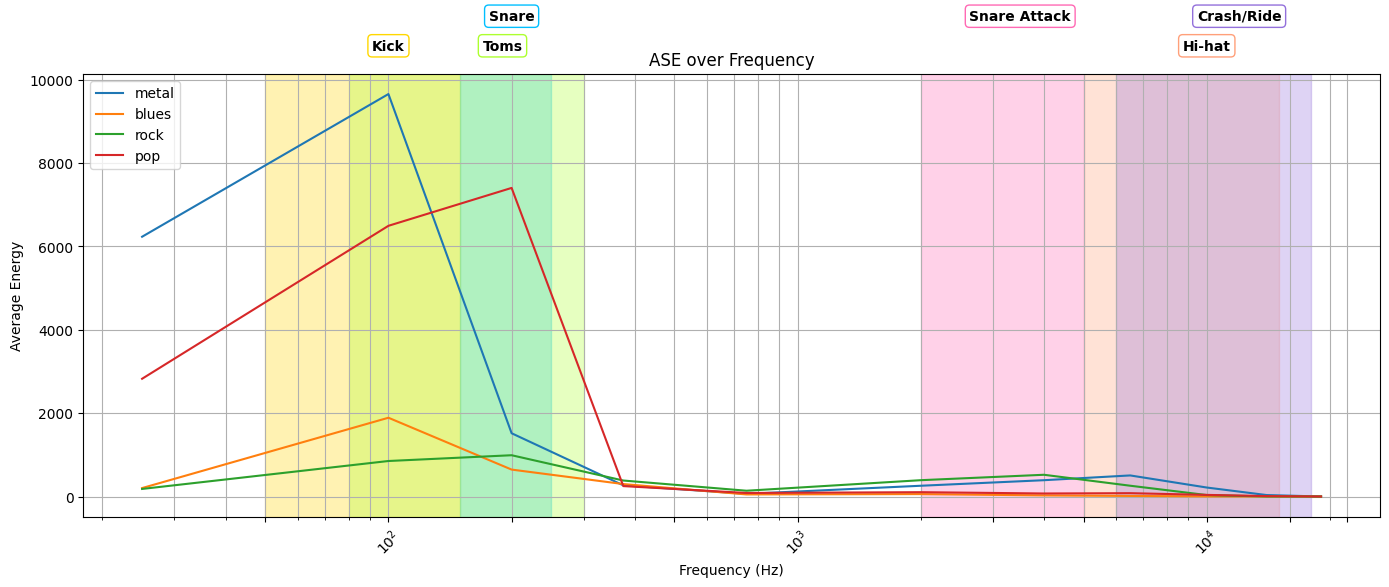

In [72]:
# ドラムに特化した帯域分割（Hz）
band_edges = np.array([
    0, 50, 150, 250, 500, 1000, 3000, 5000, 8000, 12000, 16000, 22050
])

ase_band_features = []

for filename in files:
    y, sr = librosa.load(filename, sr=None)

    # STFT
    S_complex = librosa.stft(y, n_fft=2048, hop_length=512)
    S = np.abs(S_complex) ** 2  # パワースペクトル

    freqs = np.linspace(0, sr/2, S.shape[0])

    ase_bands = []

    for i in range(len(band_edges) - 1):
        fmin = band_edges[i]
        fmax = band_edges[i+1]

        band_idx = np.where((freqs >= fmin) & (freqs < fmax))[0]

        if len(band_idx) > 0:
            band_energy = np.mean(np.sum(S[band_idx, :], axis=0))
        else:
            band_energy = 0.0

        ase_bands.append(band_energy)

    feature = {'filename': filename}
    for i, energy in enumerate(ase_bands):
        feature[f'ase_band_{i+1}'] = energy
    ase_band_features.append(feature)

# DataFrame化
df_ase = pd.DataFrame(ase_band_features)
# print(df_ase)

# 中心周波数計算（すでにあるなら不要）
center_freqs = (band_edges[:-1] + band_edges[1:]) / 2

plt.figure(figsize=(14, 6))

# データをプロット
for idx, row in df_ase.iterrows():
    ase_values = row.values[1:]  # filenameを除く
    plt.plot(center_freqs, ase_values, label=labels[idx])

# パートごとの帯域＋色を設定
drum_parts = [
    ("Kick", 50, 150, '#FFD700'),      # ゴールド
    ("Snare", 150, 250, '#00BFFF'),    # 水色
    ("Toms", 80, 300, '#ADFF2F'),       # 黄緑
    ("Snare Attack", 2000, 5000, '#FF69B4'), # ピンク
    ("Hi-hat", 5000, 15000, '#FFA07A'), # サーモンピンク
    ("Crash/Ride", 6000, 18000, '#9370DB') # 薄紫
]

# 背景色で帯を引く
for part, fmin, fmax, color in drum_parts:
    plt.axvspan(fmin, fmax, color=color, alpha=0.3)

# --- 楽器名を重ならないようにずらして配置 ---
ymax = plt.ylim()[1]

for i, (part, fmin, fmax, color) in enumerate(drum_parts):
    center = (fmin + fmax) / 2
    # 交互にy位置を上げ下げ
    if i % 2 == 0:
        y_pos = ymax * 1.05
    else:
        y_pos = ymax * 1.12

    plt.text(center, y_pos, part,
             horizontalalignment='center',
             verticalalignment='bottom',
             fontsize=10,
             fontweight='bold',
             bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.3'))

# x軸設定
plt.xscale('log')
plt.xticks([50, 100, 200, 500, 1000, 3000, 5000, 10000, 16000, 22050], rotation=45)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Average Energy')
plt.title('ASE over Frequency')
plt.legend()
plt.grid(True, which='both')

plt.tight_layout()
plt.show()


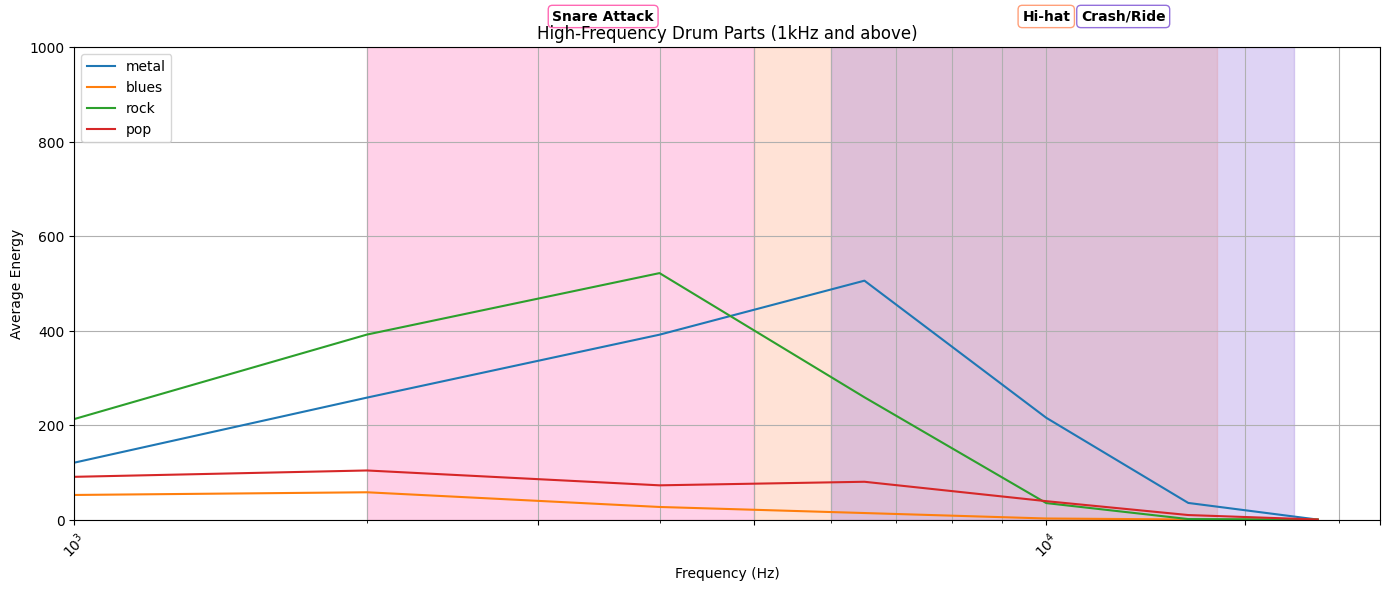

In [76]:
# 中心周波数計算（すでにあるなら不要）
center_freqs = (band_edges[:-1] + band_edges[1:]) / 2

plt.figure(figsize=(14, 6))

# データをプロット
for idx, row in df_ase.iterrows():
    ase_values = row.values[1:]  # filenameを除く
    plt.plot(center_freqs, ase_values, label=labels[idx])

# パートごとの帯域＋色設定（高音域のみ）
drum_parts = [
    ("Snare Attack", 2000, 5000, '#FF69B4'),
    ("Hi-hat", 5000, 15000, '#FFA07A'),
    ("Crash/Ride", 6000, 18000, '#9370DB')
]

# 背景帯を引く
for part, fmin, fmax, color in drum_parts:
    plt.axvspan(fmin, fmax, color=color, alpha=0.3)

# --- 楽器名をグラフの上に配置（固定y位置！）---
fixed_ypos = 1050  # 例えば固定で1050くらいにする（1000よりちょっと上）

for i, (part, fmin, fmax, color) in enumerate(drum_parts):
    center = (fmin + fmax) / 2
    plt.text(center, fixed_ypos, part,
             horizontalalignment='center',
             verticalalignment='bottom',
             fontsize=10,
             fontweight='bold',
             bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.3'))

# x軸設定
plt.xscale('log')
plt.xlim(1000, 22050)
plt.xticks([1000, 3000, 5000, 10000, 16000, 22050], rotation=45)

# y軸設定（ここで範囲指定！）
plt.ylim(0, 1000)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Average Energy')
plt.title('High-Frequency Drum Parts (1kHz and above)')
plt.legend()
plt.grid(True, which='both')

plt.tight_layout()
plt.show()
